# Optic Flow

Import the file of interest.  Call upon the ROIs (for discrete paw detection).

Rotate image. Change from 16 bit to 8 bit scaled movie. Play black and white movie.


Loading Files
-----------------------
Loading tiff file at /home/brian/Documents/testData/170620_05_fr0-299_front.tiff
Loading file took: 0.7500559190002605 sec
Converting matrix to float32
Conversion took 0.08724894300030428 sec


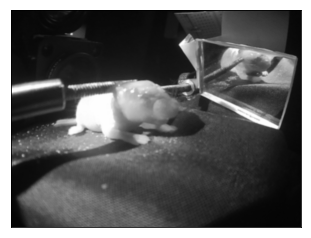

Shape of the video: (300, 480, 640)


In [7]:
from wholeBrain import *
from data_to_avi import *
import cv2
import numpy as np
import zipfile
from io import BytesIO
import time
import math
#from skimage import skimage.util.random_noise
#import skimage

#prepare movie
mov = '/home/brian/Documents/testData/170620_05_fr0-299_front.tiff'

A = loadMovie(mov).astype('uint8')

plt.imshow(A[0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

print ("Shape of the video:", A.shape)
# playMovie(A, cmap = cv2.COLORMAP_BONE)


Import the proper ROIs.  Plot the ROIs to make sure that they are correct.


Loading Rois
-----------------------
Loading ROIs at:  fpaw.R.roi
Loading ROIs at:  fpaw.L.roi
Loading ROIs at:  mouth.R.roi
Loading ROIs at:  whiskerpad.R.roi
Loading ROIs at:  hpaw.R.roi
Loading ROIs at:  tail.roi
Loading ROIs at:  belly.roi


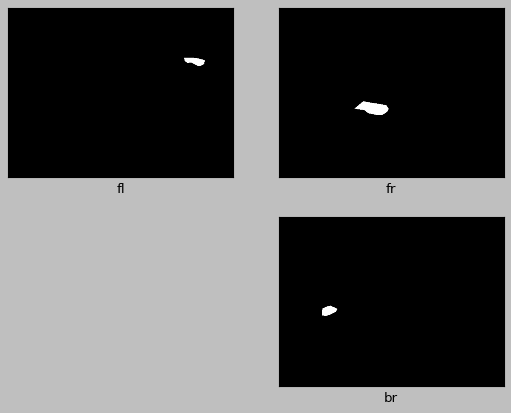

In [8]:
#prepare ROI for corner determination
ROI = '/home/brian/Documents/testData/170620_05_fr0-299_frontROIslocal.zip'
# A = rotate(loadMovie('/home/brian/Desktop/170505_02_small.tif'))

# ROI = '/home/brian/Desktop/170505_02_roiset.zip'

ROIs = roiLoader(ROI)

fl_roimask = makeMask(ROIs['fpaw.L'], A.shape[1:])
# fl_roi = ROIs['fpaw.L']
fr_roimask = makeMask(ROIs['fpaw.R'], A.shape[1:])
br_roimask = makeMask(ROIs['hpaw.R'], A.shape[1:])
# bl_roimask = makeMask(ROIs['L.b_limb'], A.shape[1:])

# print(fl_roi)
# x1, x2, y1, y2, = np.max

plt.style.use('classic')

plt.subplot(221)
plt.imshow(fl_roimask, cmap = 'gray', interpolation = 'bicubic') 
plt.xlabel('fl')
plt.xticks([]), plt.yticks([])

plt.subplot(222)
plt.imshow(fr_roimask, cmap = 'gray', interpolation = 'bicubic')
plt.xlabel('fr')
plt.xticks([]), plt.yticks([])

# plt.subplot(223)
# plt.imshow(bl_roimask, cmap = 'gray', interpolation = 'bicubic')
# plt.xlabel('bl')
# plt.xticks([]), plt.yticks([])

plt.subplot(224)
plt.imshow(br_roimask, cmap = 'gray', interpolation = 'bicubic')
plt.xlabel('br')
plt.xticks([]), plt.yticks([])

plt.show()

Problems with the current optic flow algorithm:

    1) The current edge detection requires sharp edges (therefore I was creating a mask)
        Further optimization may reduce the need to create this thresholded mask.
    2) cv2.goodFeaturesToTrack() sets the corners from the beginning of the video.  Which means if a new corner
        emerges after the start (i.e. paw comes out from beneath the animal), the code does not track it.
    3) We need to pull out vectors.  Integrate the following code into the script:
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    4) The current code traces in realtime the motion.  Should we put an option for plotting vectors?  Vector sums?
        vector averages? (in the past, vector averages of 'sampled vectors' worked well; samples vectors on those
        that were measurable: bigger than 1-2 pixel lengths, but not too large: miss-calculation due to Lucas-
        Kanade algorithm incorrectly following corner: within 2 stdev of average?).
    5) The ROIs were used to define areas of where the limbs spend the most time. What happens when they crossover?
        (less likely in the front given head restraint. more likely on hindlimbs)

The code worked fine with two ROIs. Once I built in the four ROIs, it became buggy and kept giving me errors.  

We need to rebuild the code to account for the above issues, and return the "good_new" and "good_old" values (matirx indices of the location of the corner) to do further calculations.  We will need to append all the values into a list that we could save for further computations.

In [9]:
'''	Finds too many corners... reference is always back to the first frame. 

Try to write code that will constantly update the corners.

cv2.goodFeaturesToTrack()

image – Input 8-bit or floating-point 32-bit, single-channel image.
eig_image – The parameter is ignored.
temp_image – The parameter is ignored.
corners – Output vector of detected corners.
maxCorners – Maximum number of corners to return. If there are more corners than are found, 
        the strongest of them is returned.
qualityLevel – Parameter characterizing the minimal accepted quality of image corners. The 
        parameter value is multiplied by the best corner quality measure, which is the minimal 
        eigenvalue (see cornerMinEigenVal() ) or the Harris function response (see cornerHarris() ). 
        The corners with the quality measure less than the product are rejected. For example, 
        if the best corner has the quality measure = 1500, and the qualityLevel=0.01 , then all 
        the corners with the quality measure less than 15 are rejected.
minDistance – Minimum possible Euclidean distance between the returned corners.
mask – Optional region of interest. If the image is not empty (it needs to have the type 
        CV_8UC1 and the same size as image ), it specifies the region in which the corners 
        are detected.
blockSize – Size of an average block for computing a derivative covariation matrix over 
        each pixel neighborhood. See cornerEigenValsAndVecs() .
useHarrisDetector – Parameter indicating whether to use a Harris detector (see 
        cornerHarris()) or cornerMinEigenVal().
k – Free parameter of the Harris detector.


cv2.calcOpticalFlowPyrLK()

prevImg – first 8-bit input image or pyramid constructed by buildOpticalFlowPyramid().
nextImg – second input image or pyramid of the same size and the same type as prevImg.
prevPts – vector of 2D points for which the flow needs to be found; point coordinates 
        must be single-precision floating-point numbers.
nextPts – output vector of 2D points (with single-precision floating-point coordinates) 
        containing the calculated new positions of input features in the second image; 
        when OPTFLOW_USE_INITIAL_FLOW flag is passed, the vector must have the same size 
        as in the input.
status – output status vector (of unsigned chars); each element of the vector is set to 
        1 if the flow for the corresponding features has been found, otherwise, it is set 
        to 0.
err – output vector of errors; each element of the vector is set to an error for the 
        corresponding feature, type of the error measure can be set in flags parameter; 
        if the flow wasn’t found then the error is not defined (use the status parameter 
        to find such cases).
winSize – size of the search window at each pyramid level.
maxLevel – 0-based maximal pyramid level number; if set to 0, pyramids are not used 
        (single level), if set to 1, two levels are used, and so on; if pyramids are 
        passed to input then algorithm will use as many levels as pyramids have but 
        no more than maxLevel.
criteria – parameter, specifying the termination criteria of the iterative search 
        algorithm (after the specified maximum number of iterations criteria.maxCount 
        or when the search window moves by less than criteria.epsilon.
flags –
    operation flags:

        OPTFLOW_USE_INITIAL_FLOW uses initial estimations, stored in nextPts; if the 
            flag is not set, then prevPts is copied to nextPts and is considered the 
            initial estimate.
        OPTFLOW_LK_GET_MIN_EIGENVALS use minimum eigen values as an error measure 
            (see minEigThreshold description); if the flag is not set, then L1 distance 
            between patches around the original and a moved point, divided by number of 
            pixels in a window, is used as a error measure.
            
minEigThreshold – the algorithm calculates the minimum eigen value of a 2x2 normal matrix 
            of optical flow equations (this matrix is called a spatial gradient matrix in 
            [Bouguet00]), divided by number of pixels in a window; if this value is less than 
            minEigThreshold, then a corresponding feature is filtered out and its flow is not 
            processed, so it allows to remove bad points and get a performance boost.

'''


# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100, #100 is typically enough
                        qualityLevel = 0.2,
                        minDistance = 7, #10 works well
                        blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color1 = np.random.randint(50 ,255, (100,1))
color4 = np.zeros([100,1])
color5 = 255*np.ones([100,1])

blue =  np.concatenate((color1, color4, color4), axis= 1)
red = np.concatenate((color4, color4, color1), axis= 1)
green = np.concatenate((color4, color1, color4), axis= 1)
white = np.concatenate((color5, color5, color5), axis= 1)

# Take first frame and find corners in it
old_gray = A [0, :, :].astype('uint8')
print(old_gray.dtype)

#apply different masks
#p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params) #base code

p2 = cv2.goodFeaturesToTrack(old_gray, mask = br_roimask, **feature_params) #blue
p4 = cv2.goodFeaturesToTrack(old_gray, mask = fr_roimask, **feature_params) #red
p6 = cv2.goodFeaturesToTrack(old_gray, mask = fl_roimask, **feature_params) #green
# p0 = cv2.goodFeaturesToTrack(old_gray, mask = bl_roimask, **feature_params)

'''devlop using the mask parameter to define where we get the corners.'''

# Create a mask image for drawing purposes
h = A.shape[1]
print("Height = ", h)
w = A.shape[2]
print("Width = ", w)
nframe = A.shape[0]
print("Num of Frames = ", nframe)

mask = np.zeros([h, w, 3], dtype = 'uint8')

num_masks = 3
coord = np.zeros([nframe, 1, 2])
Acolor = np.zeros([nframe, h, w, 3], dtype = 'uint8')
imageSave = np.zeros_like(Acolor)    


for n in range(nframe):
    Acolor[n] = cv2.cvtColor(A[n],cv2.COLOR_GRAY2RGB)

uint8
Height =  480
Width =  640
Num of Frames =  300


In [10]:
'''for loop to run optical flow'''

for n in range((nframe-1)):
    frame_gray = A[n+1]

    # calculate optical flow
#     p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
##################################    
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p2, None, **lk_params)

    # Select good points (blue)
    good_new_b = p1[st==1]
    good_old_b = p2[st==1]
    if n == 0:
        print ("ROI 1 good points = ", good_new_b.shape[0])
    for i,(new,old) in enumerate(zip(good_new_b,good_old_b)):
        #store points from frame to frame(blue)
        if n == 0:
            bpts = np.zeros((nframe, good_new_b.shape[0], good_new_b.shape[1]))
            bpts [n, i, :] = old
        bpts [n+1, i, :] = new 
        #draw points and lines (blue)
        c,d = old.ravel()
        a,b = new.ravel()
        mask = cv2.line(mask, (a,b), (c,d), blue[i].tolist(), 2)
        frame = cv2.circle(Acolor[n+1], (a,b), 5, blue[i].tolist(), -1)
        
###################################    
    p3, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p4, None, **lk_params)

    #Select good points (red)
    good_new_r = p3[st==1]
    good_old_r = p4[st==1]
    if n==0:
        print ("ROI 2 good points = ", good_new_r.shape[0])
        
    for i,(new,old) in enumerate(zip(good_new_r,good_old_r)):
        #store points from frame to frame (red)
        if n == 0:
            rpts = np.zeros((nframe, good_new_r.shape[0], good_new_r.shape[1]))
            rpts [n, i, :] = old
        rpts [n+1, i, :] = new
        # draw the tracks (red)   
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), red[i].tolist(), 2)
        frame = cv2.circle(frame, (a,b), 5, red[i].tolist(), -1)
        
###################################
    p5, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p6, None, **lk_params)    

    #Select good points (green)
    good_new_g = p5[st==1]
    good_old_g = p6[st==1]
    if n==0:
        print ("ROI 3 good points = ", good_old_g.shape[0])
    # draw the tracks (green)   
    for i,(new,old) in enumerate(zip(good_new_g,good_old_g)):
        #store points from frame to frame (green)
        if n == 0:
            gpts = np.zeros((nframe, good_new_g.shape[0], good_new_g.shape[1]))
            gpts [n, i, :] = old
        gpts [n+1, i, :] = new
        # draw the tracks (green)   
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), green[i].tolist(), 2)
        frame = cv2.circle(frame, (a,b), 5, green[i].tolist(), -1)
        
    img = cv2.add(frame, mask)
    imageSave [n,:,:,:] = img

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Update the previous frame and previous points
    old_gray = frame_gray.copy()
    p2 = good_new_b.reshape(-1,1,2)
    p4 = good_new_r.reshape(-1,1,2)
    p6 = good_new_g.reshape(-1,1,2)
#     p6 = good_new_w.reshape(-1,1,2)
    

#aviWrite(imageSave)
print(coord.shape)

cv2.destroyAllWindows()
for i in range(5):
    cv2.waitKey(1)

ROI 1 good points =  4
ROI 2 good points =  3
ROI 3 good points =  4
(300, 1, 2)


In [ ]:
playMovie(imageSave)

plt.imshow(imageSave[200], interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [20]:
 # for batchAngle of two vectors      
#     def unitVector(vector):
#         """ Returns the unit vector of the vector.  """
#         return vector / np.linalg.norm(vector)

#     def angleBetween(v1, v2):
#         """ Returns the angle in radians between vectors 'v1' and 'v2'"""
#         v1_u = unitVector(v1)
#         v2_u = unitVector(v2)
#         return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
#     ang = np.zeros_like(x1)
#     for n in range(x1.shape[0]):
#         newx = x2[n] - x1[n]
#         newy = y2[n] - y1[n]
#         v2 = [newx, newy]
#         v1 = [0 , y2[n]]
#         ang[n] = angleBetween(v1,v2)
#     return ang

#Find the angle with respect to the horizontal axis
def batchAngle (x1, y1, x2, y2):
    if x1.shape == x2.shape:
        if y1.shape == y2.shape:
            if x1.shape == y1.shape:
                pass
#                 print("Finding magnitude of {0} vecotrs".format(x1.shape[0]))
    else:
        raise AssertionError("Arrays are not the same shape")
        
        '''tan(theta) = dy/dx, solve for theta'''
    ang = np.zeros_like(x1)
    for n in range(x1.shape[0]):
        dx = x2[n] - x1[n]
        if dx == 0:
            dx = 0.0000001
        dy = y2[n] - y1[n]
        ang[n] = np.arctan(dy/dx)
    return np.degrees(ang)

def magnitude (x1, y1, x2 , y2):
    if x1.shape == x2.shape:
        if y1.shape == y2.shape:
            if x1.shape == y1.shape:
                pass
#                 print("Finding magnitude of {0} vecotrs".format(x1.shape[0]))
    else:
        raise AssertionError("Arrays are not the same shape")

    mag = np.zeros_like(x1)
    for n in range(x1.shape[0]):
        dx = (x1[n] - x2[n])**2
        dy = (y1[n] - y2[n])**2
        mag[n] = np.sqrt(dx + dy)
    return mag

def weightedAngleMean (mag, ang):
    if mag.shape != ang.shape:
        raise AssertionError("Arrays are not the same shape")
    
    vs = np.multiply(mag, ang) #multiply element-wise between angle and magnitude
    vsum = np.sum(vs, axis = 1) #sum the multiplication
    print("VS shape: ", vs.shape, "Vsum shape: ", vsum.shape)
    print("VS dtype: ", vs.dtype, "Vsum dtype: ", vsum.dtype)
    vweight = np.divide(vs, vsum)
    magweight = np.nanmean(np.muliply(vweight, mag))
    
    return magweight


In [18]:
gmagn = np.zeros((nframe-1, gpts.shape[1]))
bmagn = np.zeros((nframe-1, bpts.shape[1]))
rmagn = np.zeros((nframe-1, rpts.shape[1]))

gangn = np.zeros((nframe-1, gpts.shape[1]))
bangn = np.zeros((nframe-1, bpts.shape[1]))
rangn = np.zeros((nframe-1, rpts.shape[1]))

'''should we scale the front left limb due to the transfomation of the limb size imaged through the reflection? '''

for n in range(nframe-1): # should we scale because the limb is 'smaller' than the other limbs due to measurements from reflections in the mirror
    gmagn[n] = magnitude(gpts[n,:,0], gpts[n,:,1], gpts[n+1,:,0], gpts[n+1,:,1])
    gangn[n] = batchAngle(gpts[n,:,0], gpts[n,:,1], gpts[n+1,:,0], gpts[n+1,:,1])
    
for n in range(nframe-1):
    bmagn[n] = magnitude(bpts[n,:,0], bpts[n,:,1], bpts[n+1,:,0], bpts[n+1,:,1])
    bangn[n] = batchAngle(bpts[n,:,0], bpts[n,:,1], bpts[n+1,:,0], bpts[n+1,:,1])
    
for n in range(nframe-1):
    rmagn[n] = magnitude(rpts[n,:,0], rpts[n,:,1], rpts[n+1,:,0], rpts[n+1,:,1])
    rangn[n] = batchAngle(rpts[n,:,0], rpts[n,:,1], rpts[n+1,:,0], rpts[n+1,:,1])

Hthreshold = 25 #High threshold of magnitude. Choose value of high limit of acceptable movement vector in pixel lengths
Lthreshold = 0.5 #one diagonal unit away

#Replace all values in magnitude above the High threshold with NaN
rmagn[np.where(rmagn > Hthreshold)] = np.nan
gmagn[np.where(gmagn > Hthreshold)] = np.nan
bmagn[np.where(bmagn > Hthreshold)] = np.nan

#Take the mean movement angle of the vectors with a magnitude above the Low threshold
# rangn[np.where(rmagn < Lthreshold)] = np.nan
rangmean = np.nanmean(rangn, axis = 1)
# gangn[np.where(gmagn < Lthreshold)] = np.nan
gangmean = np.nanmean(gangn, axis = 1)
# bangn[np.where(bmagn < Lthreshold)] = np.nan
bangmean = np.nanmean(bangn, axis = 1)


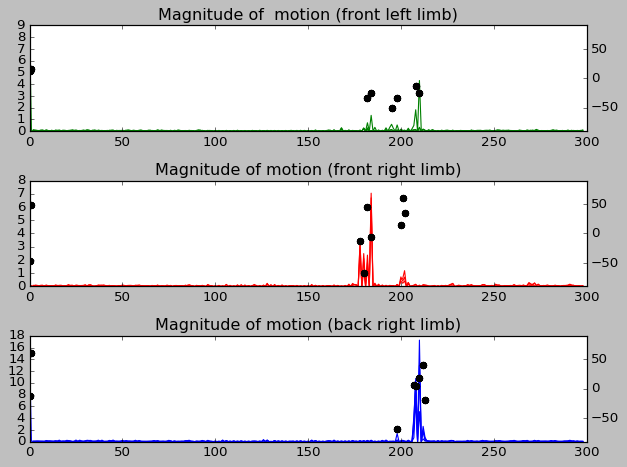

In [13]:
''' graph magnitudes and angles'''
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.subplot(3, 1, 1)
ax = plt.gca()
ax2 = ax.twinx()
for n in range(gmagn.shape[1]):
    ax.plot(gmagn[:,n], 'g-')
    ax2.plot(range(299), gangmean, 'ko')
plt.title('Magnitude of  motion (front left limb)')
# plt.title('Magnitude of  motion (front left limb)')
# ax.set_ylim([0,1])
# ax.set_xlim([0,20])
ax2.set_ylim([-90, 90])


plt.subplot(3, 1, 2)
ax = plt.gca()
ax2 = ax.twinx()
for n in range(rmagn.shape[1]):
    ax.plot(rmagn[:,n], 'r-')
    ax2.plot(range(299), rangmean, 'ko')
plt.title('Magnitude of motion (front right limb)')
# plt.title('Magnitude of motion (front right limb)')
# ax.set_ylim([0,6])
# ax.set_xlim([0,20])
ax2.set_ylim([-90, 90])


plt.subplot(3, 1, 3)
ax = plt.gca()
ax2 = ax.twinx()
for n in range(bmagn.shape[1]):
    ax.plot(bmagn[:,n], 'b-')
    ax2.plot(range(299), bangmean, 'ko')
plt.title('Magnitude of motion (back right limb)')
# plt.title('Magnitude of motion (hind right limb)')
# ax.set_ylim([0,1])
# ax.set_xlim([0,20])
ax2.set_ylim([-90, 90])

fig.tight_layout()
plt.show()


# fig.savefig('/home/brian/Documents/figures/170623_localized_roi_choice.png')

In [21]:
#Take mean and max of magnitudes
# rmagn[np.where(rmagn < Lthreshold)] = np.nan
# gmagn[np.where(gmagn < Hthreshold)] = np.nan
# bmagn[np.where(bmagn < Hthreshold)] = np.nan

gmagnmean = np.nanmean(gmagn, axis = 1)
rmagnmean = np.nanmean(rmagn, axis = 1)
bmagnmean = np.nanmean(bmagn, axis = 1)
magmean = np.stack((gmagnmean, rmagnmean, bmagnmean), axis=1)

gmagnmax = np.nanmax(gmagn, axis = 1)
rmagnmax = np.nanmax(rmagn, axis = 1)
bmagnmax = np.nanmax(bmagn, axis = 1)
magmax = np.stack((gmagnmax, rmagnmax, bmagnmax), axis=1)

gangwmean = weightedAngleMean (gmagn, gangn)
rangwmean = weightedAngleMean (rmagn, rangn)
bangwmean = weightedAngleMean (bmagn, bangn)
angmax = np.stack((gangwmean, rangwmean, bangwmean), axis=1)

labels = ['front left', 'front right', 'rear right']

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
cax = plt.imshow(magmean.T, cmap='jet', interpolation = 'none', aspect = 'auto')

plt.title('Magnitude of motion (Mean)')
fig.colorbar(cax)
# cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
plt.yticks([0,1,2], labels, rotation='horizontal')
plt.show()


fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
cam = plt.imshow(magmax.T, cmap='jet', interpolation = 'none', aspect = 'auto')

plt.title('Magnitude of motion (Max)')
plt.yticks([0,1,2], labels, rotation='horizontal')
fig.colorbar(cam)
plt.show()


ValueError: operands could not be broadcast together with shapes (299,4) (299,) 

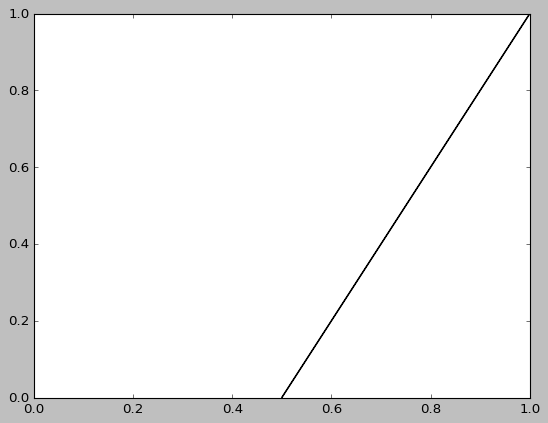

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

DATA = np.random.rand(5,5)

cmap = plt.cm.jet

cNorm  = colors.Normalize(vmin=np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))

scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

for idx in range(0,len(DATA[:,1])):
    colorVal = scalarMap.to_rgba(DATA[idx,4])
    plt.arrow(DATA[idx,0],  #x1
              DATA[idx,1],  # y1
              DATA[idx,2]-DATA[idx,0], # x2 - x1
              DATA[idx,3]-DATA[idx,1], # y2 - y1
              color=colorVal)

plt.show()  


import matplotlib.pyplot as plt

ax = plt.axes()
ax.arrow(0.5, 0, 0.5, 1, head_width=0.05, head_length=0.05, fc='k', ec='k')
#ax.arrow(t, 0, dx, dy, head_width=0.05, head_length=0.05, fc='k', ec='k')
#dx = magnitude * cos(theta)
#dy = magnitude * sin(theta)

plt.show(dy

In [14]:
i,j = np.where(bmagn > Lthreshold)
print("Frames where motion occured: ", np.unique(i))

smove = None
buf = 5 # 1 sec buffer for a unique motion to occur
for n in range(len(np.unique(i))):
    if n == 0:
        if np.unique(i)[n] != 0:
            smove = np.unique(i)[0]
    if n > 0:
        if (np.unique(i)[n-1] + buf) < np.unique(i)[n]:
            if smove is None:
                smove = np.unique(i)[n]
            else:
                smove = np.append(smove, np.unique(i)[n])

print("Start of movement indices: ", smove)
            
ibin = np.bincount(np.array(i))

# print("number of vecotors in each frame:", ibin)

Frames where motion occured:  [  0 198 207 208 210 212 213]
Start of movement indices:  [198 207]


In [ ]:
# matplotlib inline
import pylab as pl
import numpy as np

fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

# N = 100
# theta = np.random.rand(N)*np.pi*2
# r = np.cos(theta*2) + np.random.randn(N)*0.1
for n in range(len(np.unique(i))):
    axs[n] = plt.subplot(polar=True)
    axs[n].scatter(bangn[n], bmagn[n])
    axs[n].set_title(np.unique(i)[n])

# ax[n] = plt.subplot(111, polar=True)
# ax.scatter(bangn[n], bmagn[n])
# circle = pl.Circle((rangn, rmagn), 0.2, transform=ax.transData._b, color="red", alpha=0.4)
# ax.add_artist(circle)

In [ ]:
'''
Don't run this portion. Get rid of this code?

Creating a binary image to run the optical flow on.

This produces more apparent 'edges'. While not ideal, it works somewhat well
to increase the number of traceable items.

In the future, we should not have to do this.  We need to optimize the code
such that it will run on any of the videos that are put through the code.'''


mask, threshold, blur, method, methodk = setThreshold(A)
#mask = dFoF(A)
#gray to RGB conversion, need to put colored lines/circles onto BW image
print('Resizing movie and converting it to color')
sz = mask.shape
resize_factor = 1
h = int(math.ceil (sz[1] * resize_factor))
w = int(math.ceil (sz[2] * resize_factor))

B = np.zeros([sz[0], h, w], dtype = 'uint8')
C = np.zeros([sz[0], h, w, 3], dtype = 'uint8')

for i in range(sz[0]):
    frame = mask[i,:,:]
    frameA = A[i,:,:]
    B [i, :, :] = cv2.resize(frame, (w, h), interpolation = cv2.INTER_AREA)
    frameA = cv2.resize(frameA, (w, h), interpolation = cv2.INTER_AREA)
    C [i, :, :, :] = cv2.cvtColor(frameA,cv2.COLOR_GRAY2RGB)
    #cv2.applyColorMap(frameA, cv2.COLORMAP_JET, C[i,:,:,:])

rl_roimask = cv2.resize(rl_roimask, (w, h), interpolation = cv2.INTER_AREA)
rr_roimask = cv2.resize(rr_roimask, (w, h), interpolation = cv2.INTER_AREA)
fl_roimask = cv2.resize(fl_roimask, (w, h), interpolation = cv2.INTER_AREA)
fr_roimask = cv2.resize(fr_roimask, (w, h), interpolation = cv2.INTER_AREA)

Attempt at recording 'changes' from frame to frame.  Pull out magnitude and angles of the vectors:

In [ ]:
ch_size = changes.shape
print(ch_size)
der_changes = np.zeros([sz[0], 100, 2])
for n in range(ch_size[0]-1):
    der_changes [n, :, :] = changes[n-1,:,:] - changes[n,:,:]
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

index = np.transpose((np.where(der_changes > 3)))
rerun = np.array([5,6,14,20,25,28,29,30], dtype = 'uint8')
print(index)

Attempt at only plotting the selected "corners" that moved and were 'good':

In [ ]:

color1 = np.random.randint(0 ,255, (100,3))
color4 = np.zeros([100,1])
color5 = 255*np.ones([100,1])
color2 = np.random.randint(0 ,50, (100,1))
color3 = np.random.randint(0, 50, (100,1)) 
color =  np.concatenate((color5, color4, color4), axis=1 )

mask = np.zeros([w, h, 3], dtype = 'uint8')
imageSave = np.zeros([sz[0], w, h, 3], dtype = 'uint8')

for n in range((sz[0]-1)):
    frame = A[n+1, :, :, :]
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    #p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if n == 1:
        good_new = np.array(changes[n+1, rerun, :], dtype = 'uint8')
        good_old = np.array(changes[n, rerun, :], dtype = 'uint8')
        print(good_new.shape)
        print(good_old.shape)

    # draw the tracks
    for i in range (len(rerun)):
        a,b = good_new[i,:]
        c,d = good_old[i,:]
        mask = cv2.line(mask, (a,b), (c,d), color1[i].tolist(), 2)
        frame = cv2.circle(frame2, (a,b), 5, color1[i].tolist(), -1)
    img = cv2.add(frame, mask)
    imageSave [n,:,:,:] = img

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    #p0 = good_new.reshape(-1,1,2)

#aviWrite(imageSave)

cv2.destroyAllWindows()
for i in range(5):
    cv2.waitKey(1)

Second example of optic flow for tracking:

In [ ]:
#from https://github.com/npinto/opencv/blob/master/samples/python2/lk_track.py
#Key part of the code that updates obects to track every 5 frames.
'''
Lucas-Kanade tracker
====================
Lucas-Kanade sparse optical flow demo. Uses goodFeaturesToTrack
for track initialization and back-tracking for match verification
between frames.
Usage
-----
lk_track.py [<video_source>]
Keys
----
ESC - exit
'''

import numpy as np
import cv2
import video
from common import anorm2, draw_str
from time import clock

lk_params = dict( winSize  = (15, 15), 
                  maxLevel = 2, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))    

feature_params = dict( maxCorners = 500, 
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

class App:
    def __init__(self, video_src):
        self.track_len = 10
        self.detect_interval = 5
        self.tracks = []
        self.cam = video.create_capture(video_src)
        self.frame_idx = 0

    def run(self):
        while True:
            ret, frame = self.cam.read()
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            vis = frame.copy()

            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                p0 = np.float32([tr[-1] for tr in self.tracks]).reshape(-1, 1, 2)
                p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
                p0r, st, err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
                d = abs(p0-p0r).reshape(-1, 2).max(-1)
                good = d < 1
                new_tracks = []
                for tr, (x, y), good_flag in zip(self.tracks, p1.reshape(-1, 2), good):
                    if not good_flag:
                        continue
                    tr.append((x, y))
                    if len(tr) > self.track_len:
                        del tr[0]
                    new_tracks.append(tr)
                    cv2.circle(vis, (x, y), 2, (0, 255, 0), -1)
                self.tracks = new_tracks
                cv2.polylines(vis, [np.int32(tr) for tr in self.tracks], False, (0, 255, 0))
                draw_str(vis, (20, 20), 'track count: %d' % len(self.tracks))

            if self.frame_idx % self.detect_interval == 0:
                mask = np.zeros_like(frame_gray)
                mask[:] = 255
                for x, y in [np.int32(tr[-1]) for tr in self.tracks]:
                    cv2.circle(mask, (x, y), 5, 0, -1)
                p = cv2.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
                if p is not None:
                    for x, y in np.float32(p).reshape(-1, 2):
                        self.tracks.append([(x, y)])


            self.frame_idx += 1
            self.prev_gray = frame_gray
            cv2.imshow('lk_track', vis)

            ch = 0xFF & cv2.waitKey(1)
            if ch == 27:
                break

def main():
    import sys
    try: video_src = sys.argv[1]
    except: video_src = 0

    print __doc__
    App(video_src).run()
    cv2.destroyAllWindows() 			

if __name__ == '__main__':
    main()

Third example, but this one using Farneback equation which tracks 3D objects:

In [ ]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100, #100 is typically enough
                        qualityLevel = 0.1,
                        minDistance = 7, #10 works well
                        blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color1 = np.random.randint(205 ,255, (100,1))
color4 = np.zeros([100,1])
color5 = 255*np.ones([100,1])
color2 = np.random.randint(0 ,50, (100,1))
color3 = np.random.randint(0, 50, (100,1)) 
color =  np.concatenate((color1, color4, color4), axis=1 )

# Take first frame and find corners in it
prvs = B [1, :, :, :]
frame1 = cv2.cvtColor(prvs, cv2.COLOR_BGR2GRAY)

imageSave = np.zeros_like(frame)    
#np.zeros([sz[0], sz[]1, h, 3], dtype = 'uint8')
changes = np.zeros([sz[0],100, 2])

hsv = np.zeros_like(frame1)
hsv[...,1] = 255


#for n in range((sz[0]-1)):
while(1):
    frame2 = B[n+1, :, :, :]
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cv2.destroyAllWindows()
for i in range(5):
    cv2.waitKey(1)

In [ ]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.2,  
                       minDistance = 7, 
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Create a mask image for drawing purposes
mask = np.zeros([w, h, 3], dtype = 'uint8')
imageSave = np.zeros([sz[0], w, h, 3], dtype = 'uint8')


for n in range((sz[0]-1)):
    old_frame = A[n, :, :, :]
    new_frame = A[n+1, :, :, :]
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    new_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = roimask, **feature_params)
    p1, status, error = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[status==1]
    good_old = p0[status==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a,b), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)
    imageSave [n,:,:,:] = img

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old = frame.copy()
    p0 = good_new.reshape(-1,1,2)

#aviWrite(imageSave)

cv2.destroyAllWindows()
for i in range(5):
    cv2.waitKey(1)

In [ ]:
import cv2
import numpy as np
cap = cv2.VideoCapture("vtest.avi")


ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()

In [ ]:
import numpy as np
import cv2
import video

help_message = '''
USAGE: opt_flow.py [<video_source>]
Keys:
 1 - toggle HSV flow visualization
 2 - toggle glitch
'''

def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

if __name__ == '__main__':
    import sys
    print (help_message)
    try: fn = sys.argv[1]
    except: fn = 0

    cam = video.create_capture(fn)
    ret, prev = cam.read()
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    show_hsv = False
    show_glitch = False
    cur_glitch = prev.copy()

    while True:
        ret, img = cam.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prevgray, gray, 0.5, 3, 15, 3, 5, 1.2, 0)
        prevgray = gray
        
        cv2.imshow('flow', draw_flow(gray, flow))
        if show_hsv:
            cv2.imshow('flow HSV', draw_hsv(flow))
        if show_glitch:
            cur_glitch = warp_flow(cur_glitch, flow)
            cv2.imshow('glitch', cur_glitch)

        ch = 0xFF & cv2.waitKey(5)
        if ch == 27:
            break
        if ch == ord('1'):
            show_hsv = not show_hsv
            print ('HSV flow visualization is', ['off', 'on'][show_hsv])
        if ch == ord('2'):
            show_glitch = not show_glitch
            if show_glitch:
                cur_glitch = img.copy()
            print ('glitch is', ['off', 'on'][show_glitch])
    cv2.destroyAllWindows() 			

In [ ]:
'''
Lucas-Kanade tracker
====================
Lucas-Kanade sparse optical flow demo. Uses goodFeaturesToTrack
for track initialization and back-tracking for match verification
between frames.
Usage
-----
lk_track.py [<video_source>]
Keys
----
ESC - exit
'''

import numpy as np
import cv2
import video
from common import anorm2, draw_str
from time import clock

lk_params = dict( winSize  = (15, 15), 
                  maxLevel = 2, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))    

feature_params = dict( maxCorners = 500, 
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

class App:
    def __init__(self, video_src):
        self.track_len = 10
        self.detect_interval = 5
        self.tracks = []
        self.cam = video.create_capture(video_src)
        self.frame_idx = 0

    def run(self):
        while True:
            ret, frame = self.cam.read()
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            vis = frame.copy()

            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                p0 = np.float32([tr[-1] for tr in self.tracks]).reshape(-1, 1, 2)
                p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
                p0r, st, err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
                d = abs(p0-p0r).reshape(-1, 2).max(-1)
                good = d < 1
                new_tracks = []
                for tr, (x, y), good_flag in zip(self.tracks, p1.reshape(-1, 2), good):
                    if not good_flag:
                        continue
                    tr.append((x, y))
                    if len(tr) > self.track_len:
                        del tr[0]
                    new_tracks.append(tr)
                    cv2.circle(vis, (x, y), 2, (0, 255, 0), -1)
                self.tracks = new_tracks
                cv2.polylines(vis, [np.int32(tr) for tr in self.tracks], False, (0, 255, 0))
                draw_str(vis, (20, 20), 'track count: %d' % len(self.tracks))

            if self.frame_idx % self.detect_interval == 0:
                mask = np.zeros_like(frame_gray)
                mask[:] = 255
                for x, y in [np.int32(tr[-1]) for tr in self.tracks]:
                    cv2.circle(mask, (x, y), 5, 0, -1)
                p = cv2.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
                if p is not None:
                    for x, y in np.float32(p).reshape(-1, 2):
                        self.tracks.append([(x, y)])


            self.frame_idx += 1
            self.prev_gray = frame_gray
            cv2.imshow('lk_track', vis)

            ch = 0xFF & cv2.waitKey(1)
            if ch == 27:
                break

def main():
    import sys
    try: video_src = sys.argv[1]
    except: video_src = 0

    print __doc__
    App(video_src).run()
    cv2.destroyAllWindows() 			

if __name__ == '__main__':
    main()

In [ ]:
import cv2
import numpy as np
cap = cv2.VideoCapture("vtest.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',bgr)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',bgr)
    prvs = next

cap.release()
cv2.destroyAllWindows()
